In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import radians, cos, sin, asin, sqrt
# Load dataset
df = pd.read_csv("uber.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [2]:
# Data Cleaning
df.dropna(inplace=True)
df = df[df['fare_amount'] > 0]
df = df[df['passenger_count'].between(1, 6)]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199268 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199268 non-null  int64  
 1   key                199268 non-null  object 
 2   fare_amount        199268 non-null  float64
 3   pickup_datetime    199268 non-null  object 
 4   pickup_longitude   199268 non-null  float64
 5   pickup_latitude    199268 non-null  float64
 6   dropoff_longitude  199268 non-null  float64
 7   dropoff_latitude   199268 non-null  float64
 8   passenger_count    199268 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.2+ MB


In [4]:
print(df.head())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [5]:
# Haversine Distance Function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199268 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199268 non-null  int64  
 1   key                199268 non-null  object 
 2   fare_amount        199268 non-null  float64
 3   pickup_datetime    199268 non-null  object 
 4   pickup_longitude   199268 non-null  float64
 5   pickup_latitude    199268 non-null  float64
 6   dropoff_longitude  199268 non-null  float64
 7   dropoff_latitude   199268 non-null  float64
 8   passenger_count    199268 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.2+ MB


In [6]:
# Feature Engineering
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.weekday
df['distance_km'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'],
                                                   row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

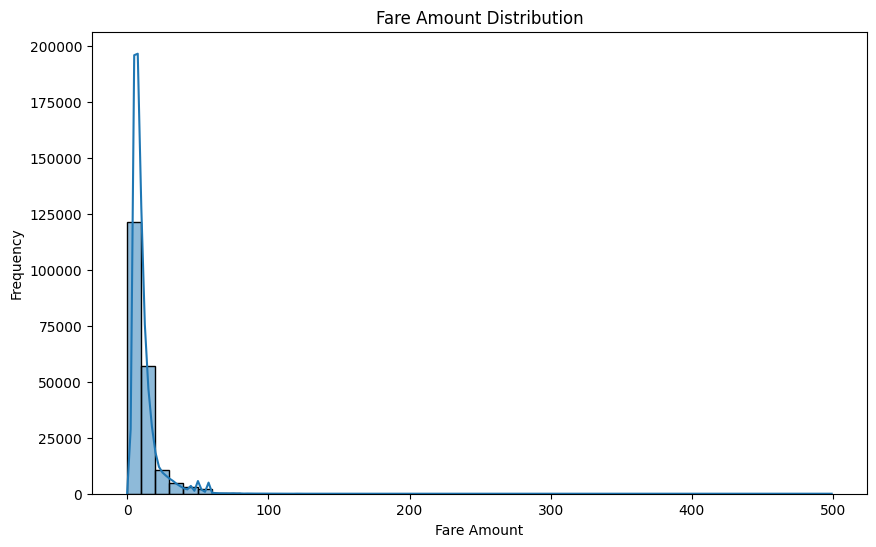

In [7]:
# EDA Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()

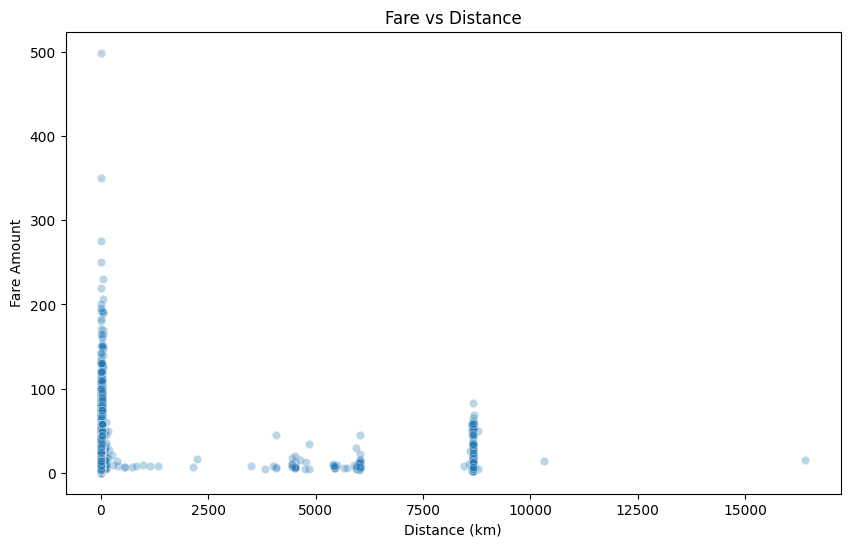

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_km', y='fare_amount', data=df, alpha=0.3)
plt.title("Fare vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount")
plt.show()

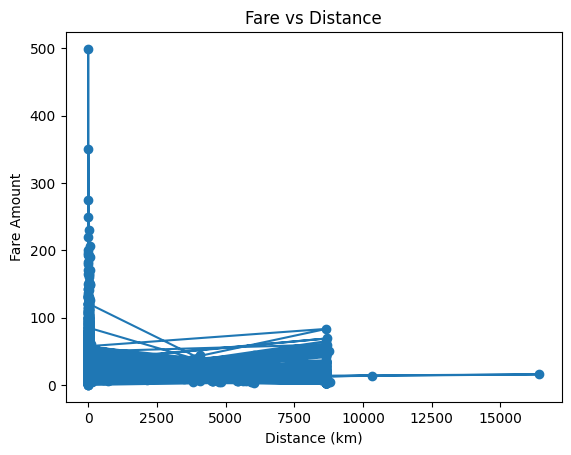

In [9]:
plt.plot(df['distance_km'], df['fare_amount'], marker='o')
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount")
plt.title("Fare vs Distance")
plt.show()

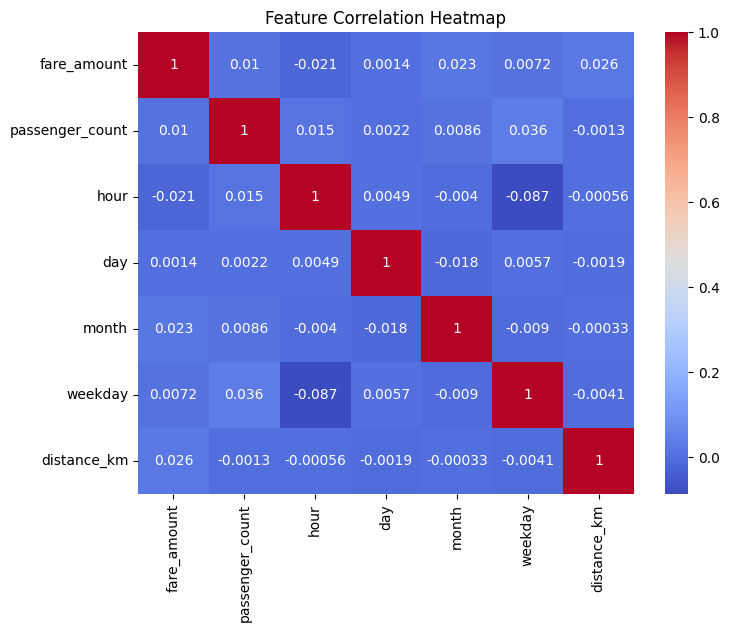

In [10]:
plt.figure(figsize=(8, 6))
corr = df[['fare_amount', 'passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [11]:
# Select Features
features = ['passenger_count', 'hour', 'day', 'month', 'weekday', 'distance_km']
X = df[features]
y = df['fare_amount']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train

,passenger_count,hour,day,month,weekday,distance_km
154597,1,15,31,3,5,1.178003
511,1,20,13,8,3,2.446986
183563,1,17,28,3,2,21.454010
135929,1,12,7,12,1,4.188323
16065,1,21,2,9,3,3.090488
...,...,...,...,...,...,...
120317,3,11,8,8,2,2.303549
104071,2,22,8,10,1,1.581135
132409,1,15,8,1,3,1.463472
147395,1,22,2,1,2,3.562675


In [15]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Print few rows of scaled training data
print("Scaled Training Data (first 10 rows):")
print(X_train_scaled_df.head(10))

# Print few rows of scaled testing data
print("\nScaled Testing Data (first 10 rows):")
print(X_test_scaled_df.head(10))

Scaled Training Data (first 10 rows):
        passenger_count      hour       day     month   weekday  distance_km
154597        -0.528271  0.230582  1.760411 -0.955415  1.004279    -0.051077
511           -0.528271  0.998439 -0.313297  0.497437 -0.023962    -0.047723
183563        -0.528271  0.537725  1.414793 -0.955415 -0.538083     0.002511
135929        -0.528271 -0.230133 -1.004533  1.659718 -1.052204    -0.043121
16065         -0.528271  1.152010 -1.580562  0.788007 -0.023962    -0.046022
122265        -0.528271 -1.765847  1.529999 -0.664845  1.518400    -0.047094
174242        -0.528271  0.077010 -0.198091 -1.245985 -1.052204    -0.049425
7513          -0.528271  0.077010  0.723557  1.659718 -1.566324    -0.043924
61504         -0.528271 -0.844418 -0.889327  1.659718 -0.538083    -0.039488
114747        -0.528271  0.384153 -1.234945  0.497437 -1.566324    -0.021779

Scaled Testing Data (first 10 rows):
        passenger_count      hour       day     month   weekday  distance_km


In [17]:
# Apply PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Print number of components chosen
print(f"Number of PCA components retained: {pca.n_components_}")

Number of PCA components retained: 6


In [18]:
X_train_pca

array([[ 0.53253397, -1.98576402,  0.21943346,  0.17785949,  0.60534481,
         0.82596003],
       [-0.79859754,  0.42582305, -0.12836826, -0.14300205,  0.11091786,
         0.8695322 ],
       [-0.79429121, -1.71220303,  0.07171274,  0.14610025,  0.42777019,
        -0.01420502],
       ...,
       [-0.25863191, -0.66668222, -0.828364  , -0.12619112, -1.49856361,
         0.16760001],
       [-1.35575011, -0.24258093, -0.70879603, -0.23088451, -2.09868024,
         0.52656486],
       [-0.68487984,  0.71283179,  1.14925236,  0.03706194,  1.78436241,
        -1.51154625]], shape=(159414, 6))

In [ ]:
# Print first 2 principal components (loadings)
print("\nFirst 2 Principal Components (weights of original features):")
print(pca.components_[:2])

# Convert to DataFrames for readability
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
X_test_pca_df  = pd.DataFrame(X_test_pca,  columns=[f"PC{i+1}" for i in range(X_test_pca.shape[1])])

# Print first 10 rows
print("\nTraining Data after PCA (first 10 rows):")
print(X_train_pca_df.head(10))

print("\nTesting Data after PCA (first 10 rows):")
print(X_test_pca_df.head(10))


First 2 Principal Components (weights of original features):
[[ 0.20013688 -0.6599805   0.02339143 -0.02288842  0.72206102 -0.04390693]
 [ 0.18853397 -0.03809423 -0.64419347  0.73382617 -0.0374682   0.09007684]]

Training Data after PCA (first 10 rows):
        PC1       PC2       PC3       PC4       PC5       PC6
0  0.532534 -1.985764  0.219433  0.177859  0.605345  0.825960
1 -0.798598  0.425823 -0.128368 -0.143002  0.110918  0.869532
2 -0.794291 -1.712203  0.071713  0.146100  0.427770 -0.014205
3 -0.773191  1.809768 -0.785414 -0.261936  0.671697 -0.441620
4 -0.936320  1.449719 -0.465358 -0.296582 -0.578718  1.053665
5  2.209149 -1.566958 -0.521030  0.194534  0.917104 -0.043171
6 -0.890252 -0.854286 -0.716386 -0.082051 -0.744854 -0.623854
7 -1.306668  0.704034 -0.138254 -0.087404  1.827853 -0.669070
8  0.005987  1.740017 -0.927890 -0.221018  0.809942 -0.485016
9 -1.529558  1.103070 -0.809929 -0.250691 -0.311173 -0.530141

Testing Data after PCA (first 10 rows):
        PC1       PC2 

Training Data (2D PCA):
        PC1       PC2
0  0.532534 -1.985764
1 -0.798598  0.425823
2 -0.794291 -1.712203
3 -0.773191  1.809768
4 -0.936320  1.449719
5  2.209149 -1.566958
6 -0.890252 -0.854286
7 -1.306668  0.704034
8  0.005987  1.740017
9 -1.529558  1.103070

Testing Data (2D PCA):
        PC1       PC2
0 -1.254653  0.104687
1  0.226494 -1.861670
2 -0.251237 -1.037933
3 -1.926911  0.919277
4 -0.168568  1.659248
5 -0.631721  0.480078
6  2.749462  2.449170
7 -0.245054 -1.037970
8 -0.235452 -0.270948
9  0.629141 -0.777811


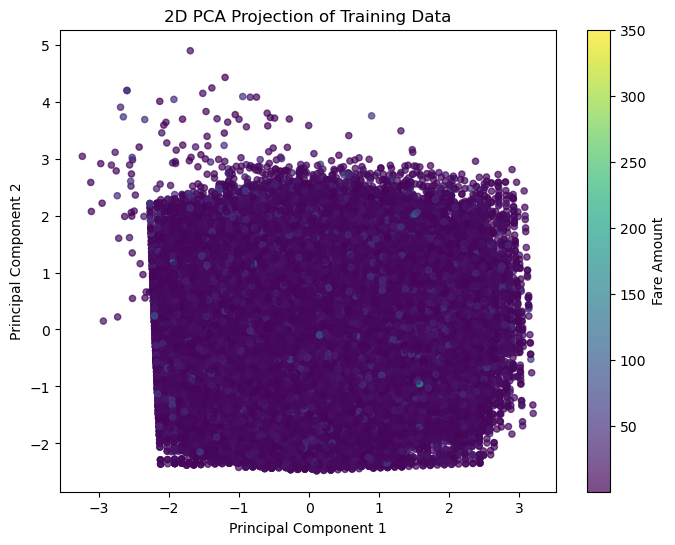

In [ ]:
# Apply PCA with 2 components
pca_2d = PCA(n_components=2, random_state=42)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
X_test_pca_2d = pca_2d.transform(X_test_scaled)

# Convert to DataFrame
X_train_pca_2d_df = pd.DataFrame(X_train_pca_2d, columns=["PC1", "PC2"])
X_test_pca_2d_df = pd.DataFrame(X_test_pca_2d, columns=["PC1", "PC2"])

# Print first 10 rows
print("Training Data (2D PCA):")
print(X_train_pca_2d_df.head(10))

print("\nTesting Data (2D PCA):")
print(X_test_pca_2d_df.head(10))

# Optional: Plot 2D PCA scatter
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca_2d[:,0], X_train_pca_2d[:,1], c=y_train, cmap="viridis", s=20, alpha=0.7)
plt.colorbar(label="Fare Amount")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection of Training Data")
plt.show()

In [ ]:
# Train Models
models = {
    "Linear Regression (No PCA)": LinearRegression().fit(X_train_scaled, y_train),
    "Linear Regression (PCA)": LinearRegression().fit(X_train_pca, y_train),
    "Random Forest (No PCA)": RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train),
    "Random Forest (PCA)": RandomForestRegressor(random_state=42).fit(X_train_pca, y_train)
}

In [ ]:
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    return {
        "R²": r2_score(y_true, y_pred),
        "RMSE": round(sqrt(mean_squared_error(y_true, y_pred)), 2)
    }

results = []

# If you trained models with different inputs (e.g., PCA vs non-PCA), handle accordingly
for name, model in models.items():
    if "PCA" in name:
        X_eval = X_test_pca
    else:
        X_eval = X_test_scaled

    metrics = evaluate(model, X_eval, y_test)
    results.append({
        "Model": name,
        "R²": round(metrics["R²"], 4),
        "RMSE": round(metrics["RMSE"], 2)
    })

results_df = pd.DataFrame(results)
print("\n Model Evaluation Results:")
print(results_df)

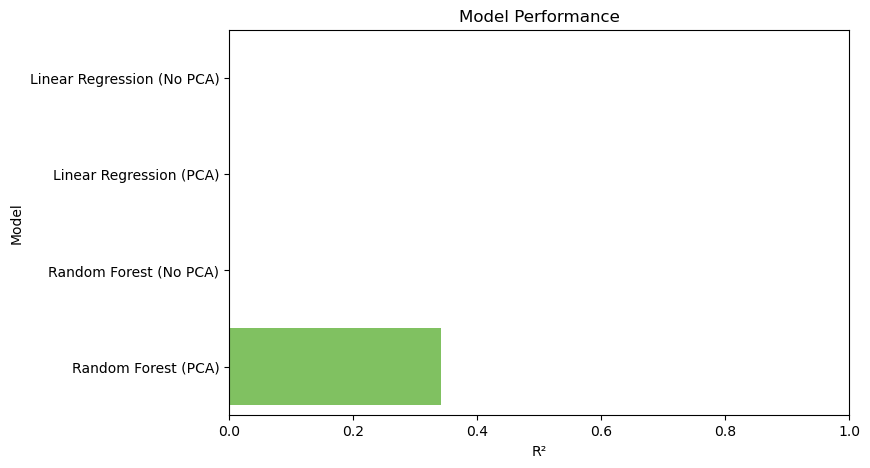

In [ ]:
# Evaluation function with R², RMSE, and MAE
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    return {
        "R²": r2_score(y_true, y_pred),
        "RMSE": sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

results = []

# Evaluate each model
for name, model in models.items():
    X_eval = X_test_pca if "PCA" in name else X_test_scaled
    metrics = evaluate(model, X_eval, y_test)
    results.append({
        "Model": name,
        "R²": round(metrics["R²"], 4),
        "RMSE": round(metrics["RMSE"], 2),
        "MAE": round(metrics["MAE"], 2)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
                        Model      R²   RMSE    MAE
0  Linear Regression (No PCA) -0.0012  10.19   6.10
1     Linear Regression (PCA)  0.0014  10.18   6.09
2      Random Forest (No PCA) -7.3120  29.37  14.55
3         Random Forest (PCA)  0.3426   8.26   4.61


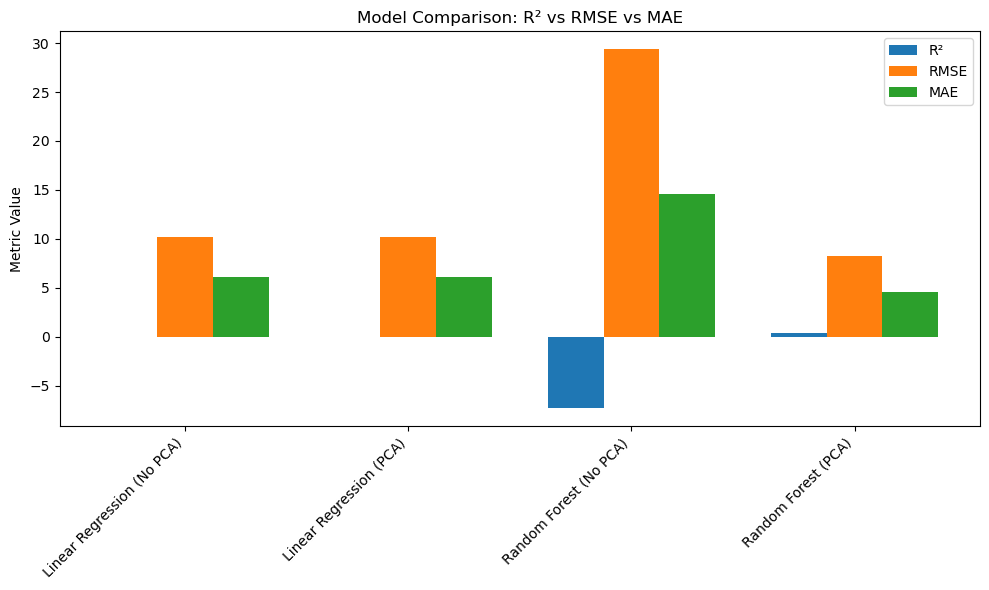

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df))

bar_width = 0.25
ax.bar([i - bar_width for i in x], results_df["R²"], width=bar_width, label="R²")
ax.bar(x, results_df["RMSE"], width=bar_width, label="RMSE")
ax.bar([i + bar_width for i in x], results_df["MAE"], width=bar_width, label="MAE")

ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=45, ha='right')
ax.set_ylabel("Metric Value")
ax.set_title("Model Comparison: R² vs RMSE vs MAE")
ax.legend()
plt.tight_layout

  ()
plt.show()